In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import functions as fs
# GradientBoostingRegressor
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer
import seaborn as sns

plt.close('all')
##################attempt number################################
# import datafile
file_path = 'docs/Data_base.xlsx'
# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path, index_col=0)

In [22]:
element_names= df.columns.tolist()[1:36]
print('Check carefully if you collect the correct elemental features name')
print('The name of the elemental features are:',element_names)

Check carefully if you collect the correct elemental features name
The name of the elemental features are: ['Ni', 'Cr', 'Co', 'Mo', 'Ti', 'Al', 'Fe', 'Mn', 'Si', 'Ta', 'C', 'B', 'P', 'Cu', 'W', 'N', 'Nb', 'V', 'S', 'Y', 'Zr', 'Pd', 'Sc', 'Mg', 'Hf', 'Ca', 'Ce', 'Tb', 'Gd', 'Sm', 'Nd', 'La', 'Pt', 'Re', 'Sn']


In [23]:
####################import feature engineering result#####################################################
file_path = 'docs/FeatureEngineering_outputlog.xlsx'
# Specify the sheet name or index you want to read
sheet_name = 'TrainsetPermutationImportance'  #TestsetPermutationImportance
# Read the Excel file into a pandas DataFrame
logdata = pd.read_excel(file_path, sheet_name=sheet_name)#, 1index_col=0
# logdata
min_row = logdata.loc[logdata['MSE_train_avg'].idxmin()]
print("***********************************************")
print("The best MSE on train set is:", min_row['MSE_train_avg'],'+-',min_row['MSE_train_std'])
print("The MSE on test set is:", min_row['MSE_test'])
print("After removing ", min_row['Number of Removed Features'], " features")
# print("The removed features are", Remove_feature[:min_index1])
print("The remained features ranks are", min_row['Feature ranking'])

***********************************************
The best MSE on train set is: 0.2102694988018041 +- 0.02141203712130297
The MSE on test set is: 0.6033602819028987
After removing  25  features
The remained features ranks are Nb, Hf, Cr, Fe, Si, DeltaSize_HEA, Ti, Co, Smix_HEA, Omega_HEA, Electroneg_HEA, Hmix_HEA, Ni, Mn, Valence_electron_concentration_ref_Avg, Al+Cr, Al, Cr/Al, invT


In [24]:
#################################################################
trainset,testset = fs.data_split(df,element_names,0.2)

comp_major_low = -0.1
comp_major_high = 100.3
comp_major_inter = 10
comp_minor_low = -0.1
comp_minor_high = 50.3
comp_minor_inter = 0.1
T_low = 10
T_high = 2510
T_inter = 50
size = 8

Sampled_trainset = fs.data_sampling(trainset,comp_major_low,comp_major_high,comp_major_inter,
                                 comp_minor_low,comp_minor_high,comp_minor_inter,
                                 T_low,T_high,T_inter,size,element_names)
#################################################################

/scratch/xt00002/T015/paper/Final/Public/functions.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Sampled_trainset = trainset.groupby(all_bin_cols, as_index=False, group_keys=False).apply(fn)


In [25]:
# #################################################################
selected_columns_sampled_trainset = Sampled_trainset.loc[:, Sampled_trainset.columns.intersection(min_row['Feature ranking'].split(', '))]
selected_columns_sampled_trainset['kp'] = Sampled_trainset['kp']

selected_columns_testset = testset.loc[:, testset.columns.intersection(min_row['Feature ranking'].split(', '))]
selected_columns_testset['kp'] = testset['kp']
####################################
X_train = selected_columns_sampled_trainset.drop(columns=['kp'])  # Exclude the target column trainset
y_train = np.log10(selected_columns_sampled_trainset['kp'])#trainset
X_test = selected_columns_testset.drop(columns=['kp'])  # Exclude the target column
y_test = np.log10(selected_columns_testset['kp'])

In [26]:
###################################################################################################################
from sklearn.kernel_ridge import KernelRidge
params = {"alpha": 0.1,"kernel": "linear"}#'rbf', 'cosine', 'sigmoid', 'polynomial', 'linear', 'chi2', 'poly', 'precomputed', 'laplacian', 'additive_chi2'
reg = KernelRidge(**params)#
###################################################################################################################
# Define the scoring metrics
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score)
}
# Perform five-fold cross-validation on the training set
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(reg, X_train, y_train, cv=kfold, scoring=scoring)

# Extract and print the cross-validation results
print("Train CV MAE Score:", cv_results['test_MAE'].mean(),'±',cv_results['test_MAE'].std())
print("Train CV MSE Score:", cv_results['test_MSE'].mean(),'±',cv_results['test_MAE'].std())
print("Train CV R2 Score:", cv_results['test_R2'].mean(),'±',cv_results['test_MAE'].std())
#################################################################################################################
# Train the model using the training set
reg.fit(X_train, y_train)

# Make predictions on the testing data
y_test_pred = reg.predict(X_test)
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_test_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_test_pred)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_test_pred)

# Print the scores
print("Test Score Mean Absolute Error (MAE):", mae)
print("Test Score Mean Squared Error (MSE):", mse)
print("Test Score R-squared (R2):", r2)

# test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
# for i, Y_pred in enumerate(reg.staged_predict(X_test)):
#     test_score[i] = mean_squared_error(y_test, Y_pred)

Train CV MAE Score: 0.34238657411477025 ± 0.01303040439811174
Train CV MSE Score: 0.21993804942429387 ± 0.01303040439811174
Train CV R2 Score: 0.8979493863726 ± 0.01303040439811174
Test Score Mean Absolute Error (MAE): 0.5751743814378056
Test Score Mean Squared Error (MSE): 0.6159818333511013
Test Score R-squared (R2): 0.7041307061844875


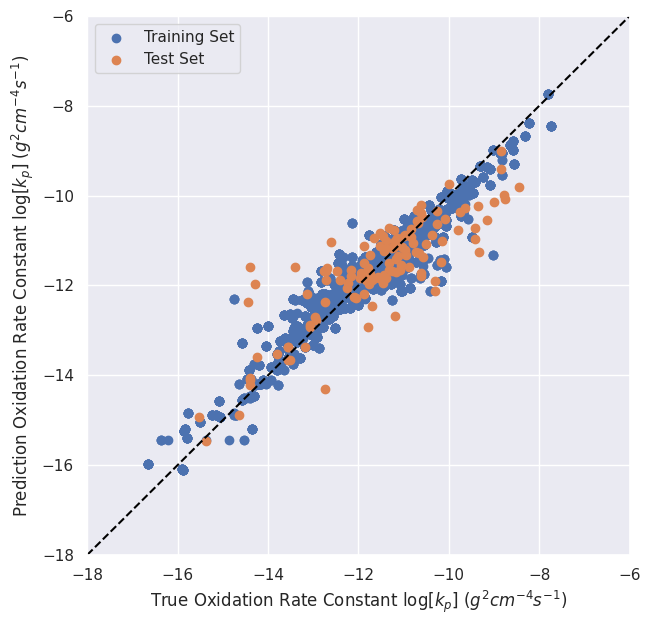

In [27]:
#################################################################
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

plt.figure(figsize=(7,7))#
linex = [-18,-2]
liney = [-18,-2]
sns.set(style="darkgrid")
plt.scatter(x=y_train,y=y_train_pred,label="Training Set")#,c='b'
plt.scatter(x=y_test,y=y_test_pred,label="Test Set")#,marker='o',edgecolors='r',c='none'
plt.plot(linex,liney,linestyle='--',color='black')#
plt.ylim(-18,-6)
plt.xlim(-18,-6)
plt.ylabel("Prediction Oxidation Rate Constant log[$k_p]$ $(g^2cm^{-4}s^{-1})$")
plt.xlabel("True Oxidation Rate Constant log[$k_p]$ $(g^2cm^{-4}s^{-1})$")
plt.legend()
### Set a high DPI for better resolution (e.g., 300)
# # Save the plot to a file with high resolution
# plt.savefig('KPRperformance.png', bbox_inches='tight')
#################################################################

In [28]:
# #################################################retain the model base on the entire database##############################
# Sampled_df = fs.data_sampling(df,comp_major_low,comp_major_high,comp_major_inter,
#                                  comp_minor_low,comp_minor_high,comp_minor_inter,
#                                  T_low,T_high,T_inter,size,element_names)
# # #################################################################
# selected_columns_sampled_df = Sampled_df.loc[:, Sampled_df.columns.intersection(min_row['Feature ranking'].split(', '))]
# selected_columns_sampled_df['kp'] = Sampled_df['kp']
# ####################################
# X_train_full = selected_columns_sampled_df.drop(columns=['kp'])  # Exclude the target column trainset
# y_train_full = np.log10(selected_columns_sampled_df['kp'])#trainset
# # Train the model using the training set
# reg.fit(X_train_full, y_train_full)

/scratch/xt00002/T015/paper/Final/Public/functions.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Sampled_trainset = trainset.groupby(all_bin_cols, as_index=False, group_keys=False).apply(fn)


GradientBoostingRegressor(learning_rate=0.03, n_estimators=400)

In [29]:
# #################SAVE-LOAD using pickle#####################
# import joblib
# joblib.dump(reg, 'KPR.pkl')

['GBR.pkl']